# TD 10 : DataFrame et Matrice (correction)



**Plan**

* [Exercice 1 : créer un fichier Excel](#exo1)
* [Exercice 2 : moyennes par groupes](#exo2)
* [Exercice 3 : régression linéaire](#exo3)

<h3 id="exo1">Exercice 1 : créer un fichier Excel</h3>
    
On souhaite récupérer les données [donnees_enquete_2003_television.txt](http://www.xavierdupre.fr/enseignement/complements/donnees_enquete_2003_television.txt) (source : [INSEE](http://www.insee.fr/fr/themes/detail.asp?ref_id=fd-hdv03&page=fichiers_detail/HDV03/telechargement.htm)).

* ``POIDSLOG`` : Pondération individuelle relative
* ``POIDSF`` : Variable de pondération individuelle
* ``cLT1FREQ`` : Nombre d'heures en moyenne passées à regarder la télévision 
* ``cLT2FREQ`` : Unité de temps utilisée pour compter le nombre d'heures passées à regarder la télévision, cette unité est représentée par les quatre valeurs suivantes
    * 0 : non concerné
    * 1 : jour
    * 2 : semaine
    * 3 : mois 
    
Ensuite, on veut :

1. Supprimer les colonnes vides
2. Obtenir les valeurs distinctes  pour la colonne ``cLT2FREQ``
3. Modifier la matrice pour enlever les lignes pour lesquelles l'unité de temps (cLT2FREQ) n'est pas renseignée ou égale à zéro.
4. Sauver le résultat au format Excel.

Vous aurez peut-être besoin des fonctions suivantes :

* [numpy.isnan](http://docs.scipy.org/doc/numpy/reference/generated/numpy.isnan.html)
* [DataFrame.apply](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html)
* [DataFrame.fillna](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) ou 
[DataFrame.isnull](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.isnull.html)
* [DataFrame.copy](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.copy.html)

In [1]:
from pyquickhelper import get_url_content
import pandas, io
text = get_url_content("http://www.xavierdupre.fr/enseignement/complements/donnees_enquete_2003_television.txt")
df = pandas.read_csv(io.StringIO(text), sep="\t")
df.head()

,POIDLOG,POIDSF,cLT1FREQ,cLT2FREQ,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31
0,0.889422,4766.865201,2,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.310209,12381.589746,30,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.740070,14685.431344,6,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.775545,9516.049939,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.732512,3925.907588,3,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
df = df [["POIDLOG","POIDSF","cLT1FREQ","cLT2FREQ"]]  # question 1
fill = df.copy()
fill.cLT2FREQ.fillna(0, inplace=True)
distinct = set(fill["cLT2FREQ"])  # question 2
print(distinct)

{0.0, 1.0, 2.0, 3.0}


In [3]:
notnull = df [ ~df.cLT2FREQ.isnull() ]  # question 3
print(len(df),len(notnull))
notnull.tail()

8403 7386


,POIDLOG,POIDSF,cLT1FREQ,cLT2FREQ
8397,0.502091,2690.961176,3,1
8398,0.306852,1644.574141,6,1
8399,2.501181,13405.104689,6,1
8400,1.382758,7410.905653,1,1
8401,0.343340,1840.132652,3,1


In [4]:
notnull.to_excel("data.xlsx")  # question 4

Pour lancer Excel, vous pouvez juste écrire ceci :

In [19]:
import os
os.system("data.xlsx")  # pour lancer Excel

0

Et vous devriez voir ce qui suit :

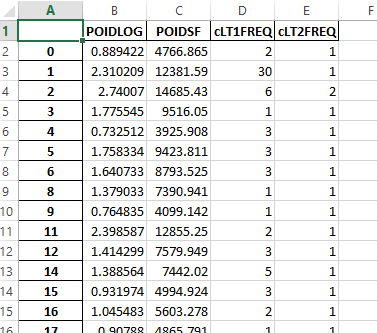

In [5]:
from pyquickhelper import NbImage
NbImage("td10exc.png")

<h3 id="exo2">Exercice 2 : moyennes par groupes</h3>
    
Toujours avec le même jeu de données ([marathon.txt](http://www.xavierdupre.fr/enseignement/complements/marathon.txt)), on veut ajouter une ligne à la fin du tableau croisé dynamique contenant la moyenne en secondes des temps des marathons pour chaque ville.

In [6]:
from pyquickhelper import read_url
import pandas
df = read_url("http://www.xavierdupre.fr/enseignement/complements/marathon.txt",
              sep="\t", names=["ville", "annee", "temps","secondes"])
df.head()

,ville,annee,temps,secondes
0,PARIS,2011,02:06:29,7589
1,PARIS,2010,02:06:41,7601
2,PARIS,2009,02:05:47,7547
3,PARIS,2008,02:06:40,7600
4,PARIS,2007,02:07:17,7637


La solution requiert trois étapes.

1. Pour avoir la moyenne par villes, il faut grouper les lignes associées à la même villes.
2. Ensuite, il faut introduire ces moyennes dans la table initiale : on fusionne.
3. On effectue le même pivot que dans l'énoncé.

In [7]:
# étape 1
# par défaut, la méthode groupby utilise la clé de group comme index
# pour ne pas le faire, il faut préciser as_index = False
gr = df[["ville","secondes"]].groupby("ville", as_index=False).mean()
gr.head()

,ville,secondes
0,AMSTERDAM,7883.371429
1,BERLIN,7922.315789
2,BOSTON,7891.061224
3,CHICAGO,7815.909091
4,FUKUOKA,8075.187500


In [8]:
# étape 2 - on ajoute une colonne
tout = df.merge( gr, on="ville")
tout.head()

,ville,annee,temps,secondes_x,secondes_y
0,PARIS,2011,02:06:29,7589,7937.028571
1,PARIS,2010,02:06:41,7601,7937.028571
2,PARIS,2009,02:05:47,7547,7937.028571
3,PARIS,2008,02:06:40,7600,7937.028571
4,PARIS,2007,02:07:17,7637,7937.028571


In [9]:
# étape 3
piv = tout.pivot("annee","ville","secondes_x")
piv.tail()

ville,AMSTERDAM,BERLIN,BOSTON,CHICAGO,FUKUOKA,LONDON,NEW YORK,PARIS,STOCKOLM
annee,,,,,,,,,
2007,7589,7466,8053,7871,7599,7661,7744,7637,8456
2008,7672,7439,7665,7585,7570,7515,7723,7600,8163
2009,7578,7568,7722,7541,7518,7510,7755,7547,8134
2010,7544,7508,7552,7583,7704,7519,7694,7601,7968
2011,NaN,7418,7382,NaN,NaN,7480,NaN,7589,8047


A partir de là, on ne voit pas trop comment s'en sortir. Voici ce que je propose :

1. On effectue un pivot sur la petite matrice des moyennes.
2. On ajoute ce second pivot avec le premier (celui de l'énoncé).

In [10]:
gr["annee"] = "moyenne"
pivmean = gr.pivot("annee","ville","secondes")
pivmean

ville,AMSTERDAM,BERLIN,BOSTON,CHICAGO,FUKUOKA,LONDON,NEW YORK,PARIS,STOCKOLM
annee,,,,,,,,,
moyenne,7883.371429,7922.315789,7891.061224,7815.909091,8075.1875,7695.16129,7928.560976,7937.028571,8133.393939


In [11]:
piv = df.pivot("annee","ville","secondes")
pandas.concat( [ piv, pivmean ]).tail()

ville,AMSTERDAM,BERLIN,BOSTON,CHICAGO,FUKUOKA,LONDON,NEW YORK,PARIS,STOCKOLM
annee,,,,,,,,,
2008,7672.000000,7439.000000,7665.000000,7585.000000,7570.0000,7515.00000,7723.000000,7600.000000,8163.000000
2009,7578.000000,7568.000000,7722.000000,7541.000000,7518.0000,7510.00000,7755.000000,7547.000000,8134.000000
2010,7544.000000,7508.000000,7552.000000,7583.000000,7704.0000,7519.00000,7694.000000,7601.000000,7968.000000
2011,NaN,7418.000000,7382.000000,NaN,NaN,7480.00000,NaN,7589.000000,8047.000000
moyenne,7883.371429,7922.315789,7891.061224,7815.909091,8075.1875,7695.16129,7928.560976,7937.028571,8133.393939


En résumé, cela donne (j'ajoute aussi le nombre de marathons courus) :

In [28]:
from pyquickhelper import read_url
import pandas
df = read_url("http://www.xavierdupre.fr/enseignement/complements/marathon.txt",
              sep="\t", names=["ville", "annee", "temps","secondes"])
gr = df[["ville","secondes"]].groupby("ville", as_index=False).mean()
gr["annee"] = "moyenne"
pivmean = gr.pivot("annee","ville","secondes")
piv = df.pivot("annee","ville","secondes")

# bizarrement, la méthode count réintroduit l'index que je pensais avoir supprimé avec
# as_index=False.
# je le supprime de nouveau avec la méthode reset_index.
# la fonction count ne compte que les valeurs non manquantes.
df2 = df.copy()
df2["nb"]=1
grc = df2[["ville","secondes","nb"]].groupby("ville", as_index=False).sum()
grc["annee"] = "nb"
pivc = grc.pivot("annee","ville","nb")

res = pandas.concat( [ piv, pivmean, pivc ])
res.tail()

ville,AMSTERDAM,BERLIN,BOSTON,CHICAGO,FUKUOKA,LONDON,NEW YORK,PARIS,STOCKOLM
annee,,,,,,,,,
2009,7578.000000,7568.000000,7722.000000,7541.000000,7518.0000,7510.00000,7755.000000,7547.000000,8134.000000
2010,7544.000000,7508.000000,7552.000000,7583.000000,7704.0000,7519.00000,7694.000000,7601.000000,7968.000000
2011,NaN,7418.000000,7382.000000,NaN,NaN,7480.00000,NaN,7589.000000,8047.000000
moyenne,7883.371429,7922.315789,7891.061224,7815.909091,8075.1875,7695.16129,7928.560976,7937.028571,8133.393939
nb,35.000000,38.000000,49.000000,33.000000,64.0000,31.00000,41.000000,35.000000,33.000000


<h3 id="exo3">Exercice 3 : régression linéaire</h3>

On reproduit le début du programme proposé par l'énoncé.

In [29]:
from pyquickhelper import read_url
from datetime import datetime, time
df = read_url("http://www.xavierdupre.fr/enseignement/complements/marathon.txt",
              sep="\t", names=["ville", "annee", "temps","secondes"])
df = df [ (df["ville"] == "BERLIN") | (df["ville"] == "PARIS") ] 
for v in ["PARIS","BERLIN"]:
    df["est" + v] = df.apply( lambda r : 1 if r["ville"] == v else 0, axis=1)
df.head(n = 3)

,ville,annee,temps,secondes,estPARIS,estBERLIN
0,PARIS,2011,02:06:29,7589,1,0
1,PARIS,2010,02:06:41,7601,1,0
2,PARIS,2009,02:05:47,7547,1,0


On va d'abord convertir la matrice en matrice ``numpy.matrix`` puis faire les calculs avec les notations matricielles :

In [30]:
import numpy
Y = numpy.matrix(df[["secondes"]].as_matrix())
X = numpy.matrix(df[["annee","estPARIS","estBERLIN"]].as_matrix())
A = (X.T * X).I * X.T * Y
A

matrix([[ -3.39257988e+01],
        [  7.55705317e+04],
        [  7.55194699e+04]])

In [31]:
numpy.column_stack([Y,X*A,X[:,1]])

matrix([[  7.58900000e+03,   7.34575036e+03,   1.00000000e+00],
        [  7.60100000e+03,   7.37967616e+03,   1.00000000e+00],
        [  7.54700000e+03,   7.41360196e+03,   1.00000000e+00],
        [  7.60000000e+03,   7.44752776e+03,   1.00000000e+00],
        [  7.63700000e+03,   7.48145356e+03,   1.00000000e+00],
        [  7.68300000e+03,   7.51537936e+03,   1.00000000e+00],
        [  7.68200000e+03,   7.54930516e+03,   1.00000000e+00],
        [  7.73600000e+03,   7.58323096e+03,   1.00000000e+00],
        [  7.59300000e+03,   7.61715675e+03,   1.00000000e+00],
        [  7.69800000e+03,   7.65108255e+03,   1.00000000e+00],
        [  7.78000000e+03,   7.68500835e+03,   1.00000000e+00],
        [  7.72900000e+03,   7.71893415e+03,   1.00000000e+00],
        [  7.69000000e+03,   7.75285995e+03,   1.00000000e+00],
        [  7.77700000e+03,   7.78678575e+03,   1.00000000e+00],
        [  7.81400000e+03,   7.82071155e+03,   1.00000000e+00],
        [  7.93800000e+03,   7.85463735e